In [1]:
using Plots
using LinearAlgebra
using Zygote
using Optim
using Base.Threads
using HDF5,Printf
# using Sys

Plot energy bands

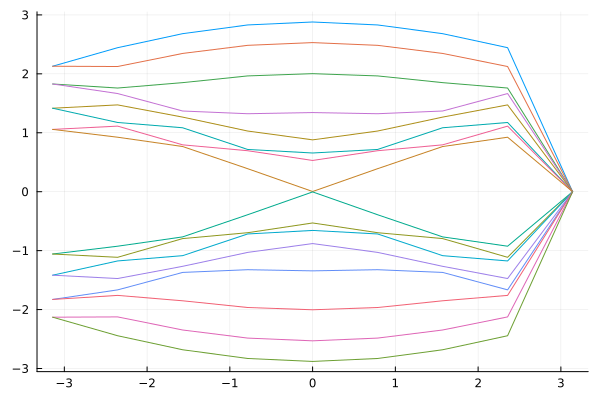

-12.030186190664901


In [37]:
params = zeros(2*N)

ky_list = LinRange(-pi, pi, nk)
dky=ky_list[2]-ky_list[1]
ene = zeros(nk,4*N)
su = 0;

for i in 1:nk-1
    ky = ky_list[i];
    h=ham(N, t, params,ky, H_order)
    eigval, U = eigen(h)
    index = sortperm(eigval, rev=true)
    sorted_eigval = eigval[index];
    # println(sorted_eigval)
    ene[i,:] = sorted_eigval;
    for j in 1:4*N
        if (ene[i,j]<=0)
            su +=ene[i,j]*(dky)/(2*pi)
        end
    end
end
p = plot(ky_list, ene[:,1], label=false)

for i in 2:4*N
    plot!(p,ky_list,ene[:,i], label=false)
end
display(p)
println(su)

Hamiltonian

In [ ]:
function hk(t,ab,N,ky)#kinetic term of Hamiltonian and ab denotes artificial bond that connects the two ends of the chain
    h=zeros(Complex{Float64},4*N,4*N)
    h_01 = zeros(Complex{Float64}, 4*N, 4*N)
    
    for i in 1:N
        h[4*i-3, 4*i-2] = -t
        h[4*i-2, 4*i-3] = -t

        h[4*i-2, 4*i-1] = -t
        h[4*i-1, 4*i-2] = -t

        h[4*i-1, 4*i] = -t
        h[4*i, 4*i-1] = -t
    end
    
    for i in 1:(N-1)
        h[4*i-3, 4*(i+1)-2] = -t
        h[4*(i+1)-2, 4*i-3] = -t

        h[4*i, 4*(i+1)-1] = -t
        h[4*(i+1)-1, 4*i] = -t
    end
    # Transport matrix
    for i in 1:N
        h_01[4*i-3, 4*i] = -t
    end
    
    #we stick two end points in x direction together

    h[4*(N-1)+1,2]+=-ab
    h[2,4*(N-1)+1]+=-ab

    h[4*N,3]+=-ab
    h[3,4*N]+=-ab

    return h + h_01 * exp(im*ky) + h_01' * exp(-im*ky)
end

# Delta term for h_delta_1
function h_delta_1(N, i)
    m = zeros(Complex{Float64}, 4*N, 4*N)
    m[4*i-2, 4*i-2] = -1
    m[4*i-1, 4*i-1] = 1
    return m
end

# Delta term for h_delta_2
function h_delta_2(N, i)
    m = zeros(Complex{Float64}, 4*N, 4*N)
    m[4*i-3, 4*i-3] = 1
    m[4*i, 4*i] = -1
    return m
end

# Hamiltonian function
function ham(N, t, params,ky, h)
    global H_order,ab
    # h_k=hk(N,ky)
    A =  hk(t,ab, N, ky);
    step_matrix = sum(params .* H_order, dims=1)#return a list with [1,4*N,4*N]
    B=step_matrix[1,:,:]
    m=A+B;
    return m
end


ham (generic function with 1 method)

$t-V$ model in real space is
\begin{equation}
    H=-t\sum(c_i^\dagger c_j+h.c.)+V\sum(n_i-\frac12)(n_j-\frac12)
\end{equation}

after the Fourier transformation, we can find inside unit cell, we have
\begin{equation}-t\sum_{k,i}(c_{k,i}^\dagger c_{k,i+1}+h.c.) + V\sum_{k,i}(n_i-\frac12)(n_{i+1}-\frac12)-V\sum \langle c_i^\dagger c_j\rangle\langle c_j^\dagger c_i\rangle\end{equation}, 
we put this term with 
\begin{equation} 
e^{ik_y}c_{1,k_y}^\dagger c_{4,k_y}
\end{equation} 
of different unit cell interaction into function "two_points". and in "four_points", we only consider the interaction from different unit cells.

In [ ]:
function two_points(ky,gamma)
    global NN_list, t, ab, V, V_ab;
    ene=0;
    for x in NN_list
        i=x[1];
        j=x[2];
        if (i % 4 == 1 && j % 4 == 0) # bond in diff unit cell
            ene+=-t * (exp(im*ky)*gamma[i,j]+exp(-im*ky)*gamma[j,i]) - V/2 * (gamma[i,i] + gamma[j,j]) * 2 + V/4 * 2; # we need to time 2 for the last 2 terms cuz we need to consider 1 to 4 and 4 to 1 for interaction.
        elseif (i == 2 && j == 4 * (N-1) + 1) || (i == 3 && j == 4 * N); #consider artificial bond
            ene += -ab*(gamma[i,j] + gamma[j,i]) + V_ab*(gamma[i,i] - 1/2)*(gamma[j,j] - 1/2) - V_ab*gamma[i,j]*gamma[j,i];
        else
            ene += -t*(gamma[i,j] + gamma[j,i]) + V*(gamma[i,i] - 1/2)*(gamma[j,j] - 1/2) - V * gamma[i,j]*gamma[j,i];
        end
    end

    return ene
end


function four_points(ky_1, ky_2 , gamma_1, gamma_2)
    global NN_list, V, nk;
    ene=0;

    for x in NN_list
        i=x[1];
        j=x[2];

        if (i % 4 == 1 && j % 4 == 0)
            ene += -V/ (nk - 1) * ( exp(im * ky_1) * exp(-im * ky_2 ) * gamma_1[i,j] * gamma_2[j,i] ) + V / (nk - 1) * (gamma_1[i,i] * gamma_2[j,j]);
            ene += -V / (nk - 1) * ( exp(-im * ky_1) * exp(im * ky_2 ) * gamma_1[j,i] * gamma_2[i,j] ) + V / (nk - 1) * (gamma_1[j,j] * gamma_2[i,i]);
        end
    end

    return ene
end

four_points (generic function with 1 method)

In [ ]:
function Gamma_matrix_diagonal(eigenval,n) #Fill the state under Fermi surface.
    Gamma_D = zeros(Complex{Float64}, 4*N, 4*N)
    k = 1;
    T = 0.00001;
    for i in 1:n
        Gamma_D[i,i] = 1 / (exp(eigenval[i] / (k * T)) + 1)
    end
    return Gamma_D
end


function mean_field(params) # Compute mean field expectation energy.
    global t, V, N, H_order, nk
    sum = Threads.Atomic{Float64}(0.0)  # Use Atomic to accumulate safely in parallel
    x = params
    ky_list = range(-pi, pi, length=nk)  # using nk to avoid the double counting of ky=pi
    dk_y = ky_list[2] - ky_list[1]
    Gamma = zeros(Complex{Float64}, nk, 4 * N, 4 * N)

    # First part: Generate Gamma matrix for each ky_list[i] in parallel
    @threads for i in 1:nk-1
        H = ham(N, t, x, ky_list[i], H_order)
        eigval, U = eigen(H)
        index = sortperm(eigval, rev=true)
        sorted_eigval = eigval[index]
        sorted_U = U[:, index]
        Gamma_D = Gamma_matrix_diagonal(sorted_eigval, 4*N);
        # println(diag(Gamma_D))
        Gamma[i, :, :] = conj(sorted_U) * Gamma_D * transpose(sorted_U)
    end

    # Second part: Compute the energy sum in parallel using two nested loops
    @threads for i in 1:nk-1
        local_sum = 0.0  # Local accumulator for energy in this thread
        local_sum += real(two_points(ky_list[i], Gamma[i, :, :]) * dk_y / (2 * pi))  # Kinetic energy

        for j in 1:nk-1
            local_sum += real(four_points(ky_list[i], ky_list[j], Gamma[i, :, :], Gamma[j, :, :]) * dk_y / (2 * pi))  # Interaction energy
        end

        # Safely update the global sum using Atomic
        atomic_add!(sum, local_sum)
    end

    return real(sum[])  # Dereference the Atomic variable to return the final sum
end

mean_field (generic function with 1 method)

In this section, we generate matrices for CDW order and list for coupling.

In [ ]:
N = 4;
t = 1;
ab = 0.01;

nk = 9;
V_ab=0;


H_order=zeros(Complex{Float64},2*N,4*N,4*N); #store the structure of CDW order. a@H_order will generate CDW matrix. a are order params
for i in 1:N
    H_order[2*i-1,:,:]=h_delta_1(N,i);
    H_order[2*i,:,:]=h_delta_2(N,i);
end

#create a list of hopping
NN_list = [zeros(Int, 2) for _ in 1:(4 * (N) + 2 * (N - 1)) + 2]#last '+2' is for kx hopping


for i in 1:N
    NN_list[4 * (i - 1) + 1] = [4 * (i - 1) + 1, 4 * (i - 1) + 2]
    NN_list[4 * (i - 1) + 2] = [4 * (i - 1) + 2, 4 * (i - 1) + 3]
    NN_list[4 * (i - 1) + 3] = [4 * (i - 1) + 3, 4 * (i - 1) + 4]
    NN_list[4 * (i - 1) + 4] = [4 * (i - 1) + 1, 4 * (i - 1) + 4]  # {0,3} coupling need to time (e^{ik_y}+e^{-ik_y})
end
for i in 1:(N-1)
    NN_list[4 * (N ) + 2 * (i - 1) + 1] = [4 * (i - 1) + 1, 4 * i + 2]
    NN_list[4 * (N ) + 2 * (i - 1) + 2] = [4 * (i - 1) + 4, 4 * i + 3]
end

NN_list[4*N + 2*(N-1) + 1] = [2, 4*(N-1) + 1];
NN_list[4*N + 2*(N-1) + 2] = [3, 4*(N)];



# Gamma_D=Gamma_matrix_diagonal(N*4);

2-element Vector{Int64}:
  3
 16

In [63]:
#auto-diff.
V=0.1;
V_ab = 0;


initial_params =  ones(2*N)*0.3;
result = optimize(mean_field, initial_params, ConjugateGradient(), Optim.Options(show_trace=true,iterations=10000))
optimal_params = Optim.minimizer(result)
minimum_value = Optim.minimum(result)

println("Optimal parameters: ", optimal_params)
println("Minimum function value: ", minimum_value)

print("N=", N,"  ","t=", t,"  ", "V=",V, "   articifial bond=",ab,"   articifial interaction=",V_ab)

Iter     Function value   Gradient norm 
     0    -1.199548e+01     2.125124e-01
 * time: 0.0009999275207519531
     1    -1.221158e+01     9.992947e-02
 * time: 0.020999908447265625
     2    -1.223582e+01     2.074617e-02
 * time: 0.0409998893737793
     3    -1.223624e+01     3.330450e-03
 * time: 0.059999942779541016
     4    -1.223625e+01     1.960437e-03
 * time: 0.07400012016296387
     5    -1.223626e+01     4.420833e-04
 * time: 0.08999991416931152
     6    -1.223626e+01     4.872529e-05
 * time: 0.12000012397766113
     7    -1.223626e+01     2.131688e-05
 * time: 0.15000009536743164
     8    -1.223626e+01     4.335833e-06
 * time: 0.16700005531311035
     9    -1.223626e+01     1.362163e-06
 * time: 0.1809999942779541
    10    -1.223626e+01     1.853961e-07
 * time: 0.19499993324279785
    11    -1.223626e+01     1.127924e-07
 * time: 0.2090001106262207
    12    -1.223626e+01     8.184416e-08
 * time: 0.22499990463256836
    13    -1.223626e+01     2.170777e-08
 * time

In [64]:
V = 0.1

mean_field(0.01*ones(2*N))

-12.236197908331702

In [3]:
Threads.nthreads()

32

Below are output.

In [27]:
open("order_parameters_N_4_ab_1.txt","w") do io
    for i in 1:n
        println(io,"when V/t=",join(string(v_list[i]/t)))
        println(io,"order parameters=",join(string(optimal_params[i,:])))
        println(io,"average order=",join(string(average_order[i])))
        println(io,join("  "))
    end
end

In [ ]:
N

In [ ]:
optimal_params=zeros(35,2*N);


In [6]:
initial_params = ones(2*N);
V=1;
optimal_params=zeros(1,2*N);
V_ab=0;
result = optimize(mean_field, initial_params, ConjugateGradient(), Optim.Options(show_trace=true,iterations=10000))

optimal_params[1,:] = Optim.minimizer(result)
minimum_value = Optim.minimum(result)

println("Optimal parameters: ", optimal_params)
println("Minimum function value: ", minimum_value)
print("N=", N,"  ","t=", t,"  ","V=", V, "  ", "articifial bond=",ab,"   articifial interaction=",V_ab)

Iter     Function value   Gradient norm 
     0    -2.507112e+01     1.859284e-01
 * time: 0.024803876876831055
     1    -2.522282e+01     2.851533e-01
 * time: 2.2634057998657227
     2    -2.550366e+01     1.775254e-01
 * time: 3.6331589221954346
     3    -2.562998e+01     4.639068e-02
 * time: 6.4083569049835205
     4    -2.564527e+01     3.219813e-02
 * time: 7.859861850738525
     5    -2.564938e+01     5.296025e-03
 * time: 9.300665855407715
     6    -2.564985e+01     3.818000e-03
 * time: 10.678728818893433
     7    -2.564991e+01     1.312285e-03
 * time: 12.183291912078857
     8    -2.564991e+01     1.958695e-04
 * time: 13.571733951568604
     9    -2.564991e+01     6.159462e-05
 * time: 15.119410991668701
    10    -2.564991e+01     3.125508e-05
 * time: 16.637589931488037
    11    -2.564991e+01     5.599724e-06
 * time: 17.965559005737305
    12    -2.564991e+01     1.662991e-06
 * time: 19.39946699142456
    13    -2.564991e+01     8.075877e-07
 * time: 20.7399988174

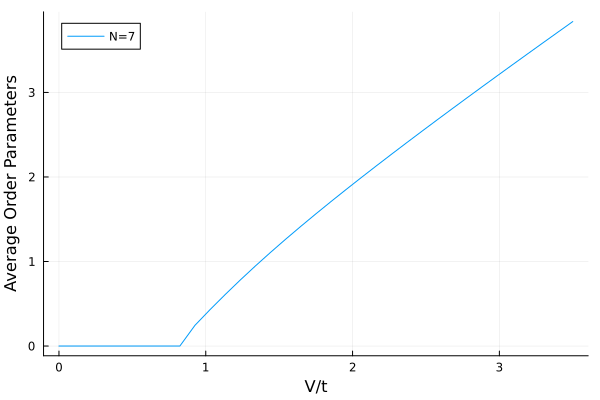

In [30]:
plot(v_list,average_order,ylabel="Average Order Parameters",xlabel="V/t",label="N=7")

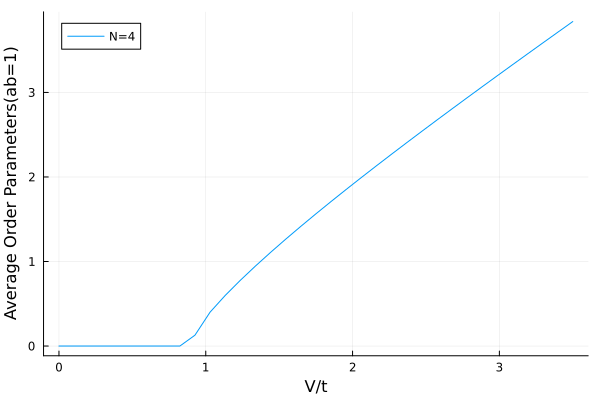

In [34]:
plot(v_list,average_order,ylabel="Average Order Parameters(ab=1)",xlabel="V/t",label="N=4")

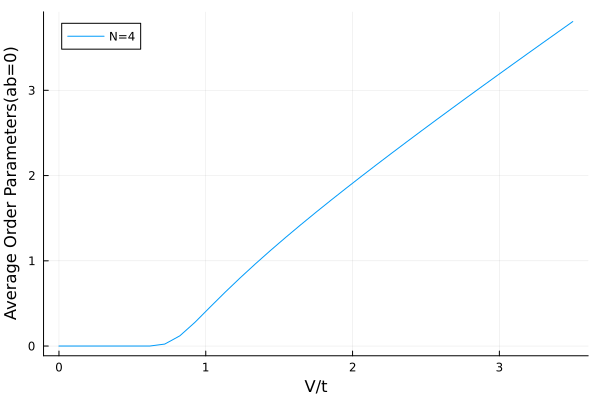

In [37]:
plot(v_list,average_order,ylabel="Average Order Parameters(ab=0)",xlabel="V/t",label="N=4")

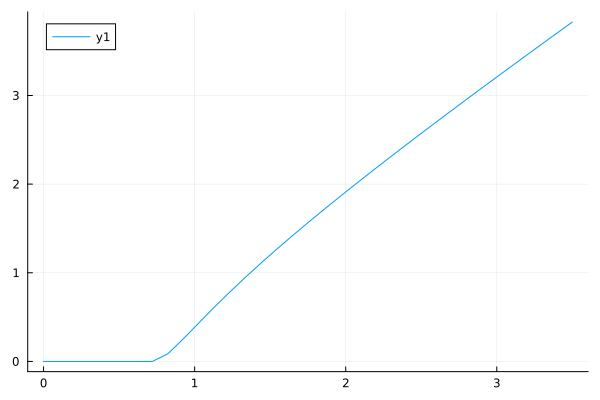

In [8]:
plot(v_list,average_order)